In [1]:
import pandas as pd
import numpy as np

In [2]:
import re

In [3]:
pd.options.display.float_format = '{:,.4f}'.format

In [4]:
aux = pd.read_excel(r'E:\Documentos\bases\indice_conectar\cobertura\cobertura_2020-12.xlsx', 
                             sheet_name='base', dtype={'COD': str}, usecols=['COD', 'Município', 'Total'])

In [5]:
aux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5590 entries, 0 to 5589
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   COD        5590 non-null   object
 1   Município  5590 non-null   object
 2   Total      5590 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 131.1+ KB


In [7]:
#Remover entradas sem identificação do município
base = aux[~aux['Município'].str.contains('ignorado', flags=re.IGNORECASE)]

In [8]:
base

,COD,Município,Total
0,110001,Alta Floresta D'Oeste,1361
1,110037,Alto Alegre dos Parecis,129
2,110040,Alto Paraíso,242
3,110034,Alvorada D'Oeste,597
4,110002,Ariquemes,7204
...,...,...,...
5583,522200,Vianópolis,906
5584,522205,Vicentinópolis,1488
5585,522220,Vila Boa,57
5586,522230,Vila Propício,127


In [9]:
print('Quantidade de municipios na base de dados: {0}'.format(len(base)))
print('Quantidade de municípios que não estão na base: {0}'.format(5568 - len(base)))

Quantidade de municipios na base de dados: 5563
Quantidade de municípios que não estão na base: 5


In [10]:
print('Quantidade de municipios sem valor(zero)')
aux['Total'].isna().sum()

Quantidade de municipios sem valor(zero)


0

In [11]:
base.describe()

,Total
count,"5,563.0000"
mean,"8,553.3646"
std,"97,127.5425"
min,1.0000
25%,103.0000
50%,373.0000
75%,"1,738.5000"
max,"5,786,466.0000"


<AxesSubplot:>

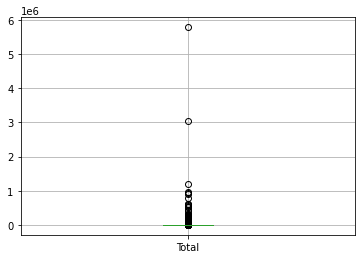

In [12]:
base[['Total']].boxplot()

array([[<AxesSubplot:title={'center':'Total'}>]], dtype=object)

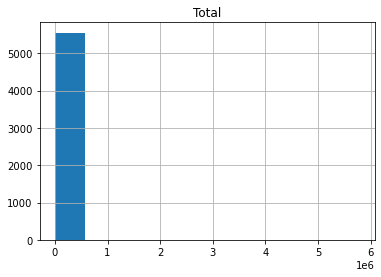

In [13]:
base[['Total']].hist()

## Razão Cobertura / População

In [14]:
#Duplica a base, com somente coluna Código e dados, renomeia colunas
cobertura_aux = base[['COD', 'Total']].copy()
cobertura_aux.rename(columns={'COD': 'COD 6', 'Total': 'cobertura_2020'}, inplace=True)

In [15]:
#Acrescenta dados da população
população = pd.read_excel(r'E:\Documentos\bases\indice_conectar\população\população_base.xlsx', dtype={'COD':str, 'COD 6': str})

#Merge das duas base
cobertura = pd.merge(população[['UF', 'COD. UF', 'COD', 'COD 6', 'NOME DO MUNICÍPIO',
       'pop_2020', 'categoria']], cobertura_aux, left_on='COD 6', right_on='COD 6', how='left')

In [16]:
#Municipios sem dados de cobertura
cobertura[cobertura['cobertura_2020'].isna()]

,UF,COD. UF,COD,COD 6,NOME DO MUNICÍPIO,pop_2020,categoria,cobertura_2020
224,PA,15,1504752,150475,Mojuí dos Campos,16184,7,nan
1431,PB,25,2514552,251455,São José de Princesa,3950,7,nan
1433,PB,25,2514651,251465,São José do Brejo do Cruz,1811,7,nan
4502,SC,42,4212650,421265,Pescaria Brava,10159,7,nan
4604,SC,42,4220000,422000,Balneário Rincão,12946,7,nan
4922,RS,43,4314548,431454,Pinto Bandeira,3036,7,nan
5159,MS,50,5006275,500627,Paraíso das Águas,5654,7,nan


In [17]:
## TRATAMENTO
##Calculando valores da média para preencher NaN

#Criar id para fazer o cruzamento
cobertura['id'] = cobertura['UF'] + cobertura['categoria'].astype(str)

#Calculando a média por estado e categoria-cidade
vazio = pd.pivot_table(cobertura, index=['UF', 'categoria'], values=['cobertura_2020'], aggfunc=np.mean).reset_index()

#Criando o id
vazio['id'] = vazio['UF'] + vazio['categoria'].astype(str)

#Preencendo o Nan
cobertura_1 = cobertura.fillna(cobertura[['id']].join(vazio.set_index('id'), on='id'))

#Removendo as colunas desnecessárias
cobertura_1.drop(['categoria', 'id'], axis=1, inplace=True)
cobertura_1

,UF,COD. UF,COD,COD 6,NOME DO MUNICÍPIO,pop_2020,cobertura_2020
0,RO,11,1100015,110001,Alta Floresta D'Oeste,22728,"1,361.0000"
1,RO,11,1100023,110002,Ariquemes,109523,"7,204.0000"
2,RO,11,1100031,110003,Cabixi,5188,164.0000
3,RO,11,1100049,110004,Cacoal,85893,"8,464.0000"
4,RO,11,1100056,110005,Cerejeiras,16204,736.0000
...,...,...,...,...,...,...,...
5563,GO,52,5221908,522190,Varjão,3838,177.0000
5564,GO,52,5222005,522200,Vianópolis,13977,906.0000
5565,GO,52,5222054,522205,Vicentinópolis,8873,"1,488.0000"
5566,GO,52,5222203,522220,Vila Boa,6312,57.0000


In [18]:
cobertura_1[cobertura_1['cobertura_2020'].isna()]

,UF,COD. UF,COD,COD 6,NOME DO MUNICÍPIO,pop_2020,cobertura_2020


In [19]:
cobertura = cobertura_1.copy()

In [20]:
cobertura['razão_cobertura-pop'] = (cobertura['cobertura_2020'] / cobertura['pop_2020'])

## Indicador

In [21]:
cobertura['indicadorCS'] = round(cobertura['razão_cobertura-pop'], 4)

In [25]:
#Lista dos Consorciados
consorciados = pd.read_excel(r'E:\Documentos\bases\cadastro\base_municipios - Definitiva 2021.xlsx', dtype={'COD IBGE': str})

base_cobertura_completa = pd.merge(cobertura, consorciados[['COD IBGE', 'Consorciado']], 
                                     left_on='COD', right_on='COD IBGE')

In [26]:
base_cobertura_completa

,UF,COD. UF,COD,COD 6,NOME DO MUNICÍPIO,pop_2020,cobertura_2020,razão_cobertura-pop,indicadorCS,COD IBGE,Consorciado
0,RO,11,1100015,110001,Alta Floresta D'Oeste,22728,"1,361.0000",0.0599,0.0599,1100015,Não
1,RO,11,1100023,110002,Ariquemes,109523,"7,204.0000",0.0658,0.0658,1100023,Sim
2,RO,11,1100031,110003,Cabixi,5188,164.0000,0.0316,0.0316,1100031,Não
3,RO,11,1100049,110004,Cacoal,85893,"8,464.0000",0.0985,0.0985,1100049,Não
4,RO,11,1100056,110005,Cerejeiras,16204,736.0000,0.0454,0.0454,1100056,Não
...,...,...,...,...,...,...,...,...,...,...,...
5563,GO,52,5221908,522190,Varjão,3838,177.0000,0.0461,0.0461,5221908,Não
5564,GO,52,5222005,522200,Vianópolis,13977,906.0000,0.0648,0.0648,5222005,Não
5565,GO,52,5222054,522205,Vicentinópolis,8873,"1,488.0000",0.1677,0.1677,5222054,Não
5566,GO,52,5222203,522220,Vila Boa,6312,57.0000,0.0090,0.0090,5222203,Não


In [27]:
#BASE CONSORCIADOS
cobertura_consorciados = base_cobertura_completa[base_cobertura_completa['Consorciado'] == 'Sim']
cobertura_consorciados = cobertura_consorciados.drop('Consorciado', axis=1)
cobertura_consorciados = cobertura_consorciados.drop('COD IBGE', axis=1)

In [28]:
cobertura_consorciados

,UF,COD. UF,COD,COD 6,NOME DO MUNICÍPIO,pop_2020,cobertura_2020,razão_cobertura-pop,indicadorCS
1,RO,11,1100023,110002,Ariquemes,109523,"7,204.0000",0.0658,0.0658
9,RO,11,1100106,110010,Guajará-Mirim,46556,"2,047.0000",0.0440,0.0440
11,RO,11,1100122,110012,Ji-Paraná,130009,"14,461.0000",0.1112,0.1112
16,RO,11,1100205,110020,Porto Velho,539354,"85,084.0000",0.1578,0.1578
34,RO,11,1100940,110094,Cujubim,26183,167.0000,0.0064,0.0064
...,...,...,...,...,...,...,...,...,...
5538,GO,52,5220058,522005,São João da Paraúna,1345,50.0000,0.0372,0.0372
5539,GO,52,5220108,522010,São Luís de Montes Belos,34157,"3,241.0000",0.0949,0.0949
5540,GO,52,5220157,522015,São Luiz do Norte,5215,62.0000,0.0119,0.0119
5554,GO,52,5221403,522140,Trindade,129823,"14,797.0000",0.1140,0.1140


In [29]:
cobertura_consorciados['indicadorCS'].describe()

count   2,134.0000
mean        0.1208
std         0.1211
min         0.0003
25%         0.0224
50%         0.0789
75%         0.1863
max         0.8283
Name: indicadorCS, dtype: float64

array([[<AxesSubplot:title={'center':'indicadorCS'}>]], dtype=object)

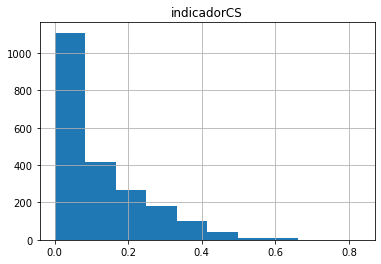

In [30]:
cobertura_consorciados[['indicadorCS']].hist()

<AxesSubplot:>

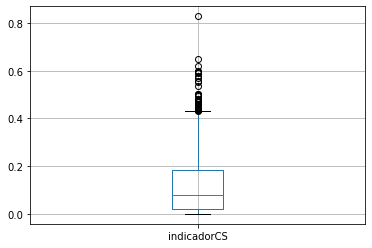

In [31]:
cobertura_consorciados[['indicadorCS']].boxplot()

In [32]:
cobertura_consorciados

,UF,COD. UF,COD,COD 6,NOME DO MUNICÍPIO,pop_2020,cobertura_2020,razão_cobertura-pop,indicadorCS
1,RO,11,1100023,110002,Ariquemes,109523,"7,204.0000",0.0658,0.0658
9,RO,11,1100106,110010,Guajará-Mirim,46556,"2,047.0000",0.0440,0.0440
11,RO,11,1100122,110012,Ji-Paraná,130009,"14,461.0000",0.1112,0.1112
16,RO,11,1100205,110020,Porto Velho,539354,"85,084.0000",0.1578,0.1578
34,RO,11,1100940,110094,Cujubim,26183,167.0000,0.0064,0.0064
...,...,...,...,...,...,...,...,...,...
5538,GO,52,5220058,522005,São João da Paraúna,1345,50.0000,0.0372,0.0372
5539,GO,52,5220108,522010,São Luís de Montes Belos,34157,"3,241.0000",0.0949,0.0949
5540,GO,52,5220157,522015,São Luiz do Norte,5215,62.0000,0.0119,0.0119
5554,GO,52,5221403,522140,Trindade,129823,"14,797.0000",0.1140,0.1140


In [33]:
cobertura_consorciados[['COD', 'cobertura_2020', 'indicadorCS']].to_excel(r'E:\Documentos\bases\indice_conectar\cobertura\indicador_cobertura.xlsx', index=False)